## Austin Texas Micromobility Analysis

Micromobility is a critical part of the transition to electric vehicles. Increasing urbanisation and dense urban cities do not couple well with large transportation vehicles, and thus cities have been struggling to come up with innovative solutions to leverage electric vehicle adoption while controlling traffic congestion. Micromobility, the idea of shared, smaller vehicles used primarily in urban settings, has emerged as a potential solution that accounts for both electric vehicle adoption and reduced traffic congestion.

The city of Austin has shared its micromobility data with the public as part of their adoption of a city-wide e-scooter program. In this notebook we'll look at the scope of how the public in Austin uses these scooters.

### Importing Libraries and Data Exploration

In [4]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import  (StringType,IntegerType,TimestampType)                               
from datetime import datetime
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import col,udf
import altair as alt


In [5]:
spark = SparkSession.builder.getOrCreate()
sc_sql = SQLContext(spark)

In [6]:
austin = spark.read.csv('austin_scooter.csv', header = 'True', inferSchema = 'True')

In [7]:
austin.count()

7521878

In [8]:
austin.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Device ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Trip Duration: integer (nullable = true)
 |-- Trip Distance: double (nullable = true)
 |-- Start Time: string (nullable = true)
 |-- End Time: string (nullable = true)
 |-- Modified Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day of Week: integer (nullable = true)
 |-- Council District (Start): string (nullable = true)
 |-- Council District (End): string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Census Tract Start: string (nullable = true)
 |-- Census Tract End: string (nullable = true)



In [9]:
austin.tail(2)

[Row(ID='9d884348-ac4d-40ab-b0a4-6d5a1f0c2aeb', Device ID='bb01f886-85e9-44d3-9c14-0c2b2c32c0cb', Vehicle Type='scooter', Trip Duration=935, Trip Distance=4145.704281096752, Start Time='01/18/2021 02:15:00 AM', End Time='01/18/2021 02:30:00 AM', Modified Date='01/19/2021 03:16:24 AM', Month=1, Hour=2, Day of Week=0, Council District (Start)='9', Council District (End)='9', Year=2021, Census Tract Start='48453001305', Census Tract End='48453001100'),
 Row(ID='e6a44faa-bbd5-4be6-a68c-ad35d0d1eb27', Device ID='9d8c5315-2f52-425d-9337-a3e9126abcf8', Vehicle Type='scooter', Trip Duration=348, Trip Distance=1270.1931092395125, Start Time='01/18/2021 02:15:00 AM', End Time='01/18/2021 02:15:00 AM', Modified Date='01/19/2021 03:16:24 AM', Month=1, Hour=2, Day of Week=0, Council District (Start)='9', Council District (End)='9', Year=2021, Census Tract Start='48453001305', Census Tract End='48453001305')]

In [10]:
austin = austin.dropna()

In [11]:
timefunc=  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S %p'), TimestampType())
austin= austin.withColumn('Start Time', timefunc(col('Start Time'))).withColumn('End Time',timefunc(col('End Time')))

In [12]:
days = {"1": "MON", "2": "TUE", "3": "WED", "4": "THU", "5": "FRI", "6": "SAT", "0": "SUN"}
days = {k:str(v) for k,v in zip(days.keys(),days.values())}
austin= austin.withColumn('Day of Week', austin['Day of Week'].cast("string"))
austin = austin.na.replace(days,1,"Day of Week")

/Users/viraj.pande/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/dataframe.py:1894: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


In [13]:
wkndF =  udf (lambda x: True if x in('SAT','SUN') else False)
austin= austin.withColumn('Is_Weekend',wkndF(austin['Day of Week']))

In [14]:
austin.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Device ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Trip_Duration(minutes): double (nullable = true)
 |-- Trip Distance: double (nullable = true)
 |-- Start Time: timestamp (nullable = true)
 |-- End Time: timestamp (nullable = true)
 |-- Modified Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Council District (Start): string (nullable = true)
 |-- Council District (End): string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Census Tract Start: string (nullable = true)
 |-- Census Tract End: string (nullable = true)
 |-- Is_Weekend: string (nullable = true)



In [15]:
austin.groupBy("Day of Week").count().sort("count",ascending=True).show()


+-----------+-------+
|Day of Week|  count|
+-----------+-------+
|        TUE| 862224|
|        MON| 864190|
|        WED| 876269|
|        THU|1010849|
|        SUN|1088408|
|        FRI|1297171|
|        SAT|1522670|
+-----------+-------+



In [16]:
austin.groupBy("Month").count().sort("count",ascending=True).show()


+-----+------+
|Month| count|
+-----+------+
|    5|481754|
|    6|482685|
|    4|497062|
|    1|503608|
|   12|510024|
|    7|541518|
|    2|550175|
|   11|687899|
|    8|758481|
|    3|779854|
|    9|856909|
|   10|871812|
+-----+------+



In [17]:
austin.crosstab('Vehicle Type', 'Month').sort("Vehicle Type_Month",ascending=True).show()


+------------------+------+------+------+------+------+------+------+------+------+------+------+------+
|Vehicle Type_Month|     1|    10|    11|    12|     2|     3|     4|     5|     6|     7|     8|     9|
+------------------+------+------+------+------+------+------+------+------+------+------+------+------+
|           bicycle| 22571| 42020| 41475| 20750| 25532| 54776| 35741| 37353| 31530| 35099| 32015| 35272|
|             moped|  6501|  5201|  9948|  7391|  6161|  5328|  3784|  7319|  8440|  7769|  6079|  3953|
|           scooter|474536|824591|636476|481883|518482|719750|457537|437082|442715|498650|720387|817684|
+------------------+------+------+------+------+------+------+------+------+------+------+------+------+



In [18]:
austin.crosstab('Day of Week', 'Month').sort("Day of Week_Month",ascending=True).show()


+-----------------+-----+------+------+------+------+------+-----+-----+------+-----+------+------+
|Day of Week_Month|    1|    10|    11|    12|     2|     3|    4|    5|     6|    7|     8|     9|
+-----------------+-----+------+------+------+------+------+-----+-----+------+-----+------+------+
|              FRI|85054|155505|128770| 66022| 82671|140067|87565|81686| 83352|90456|150777|145246|
|              MON|54715| 91705| 74225| 82701| 65859| 78368|71948|55413| 50379|63675| 73419|101783|
|              SAT|96455|167506|152351|100017|119460|160040|77291|88835|111287|99226|159400|190802|
|              SUN|72748|120728| 91708| 80553| 89007|125915|64795|76685| 72119|72296| 91953|129901|
|              THU|74038|125928| 90557| 60449| 65896|103652|68456|68512| 60641|76056|110649|106015|
|              TUE|60733|102262| 76468| 66538| 61728| 85256|74341|46861| 48530|70892| 78351| 90264|
|              WED|59865|108178| 73820| 53744| 65554| 86556|52666|63762| 56377|68917| 93932| 92898|


In [19]:
austin=austin.withColumn('Cost($)',(austin['Trip_Duration(minutes)']*0.15+1))


In [20]:
austin.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Device ID: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Trip_Duration(minutes): double (nullable = true)
 |-- Trip Distance: double (nullable = true)
 |-- Start Time: timestamp (nullable = true)
 |-- End Time: timestamp (nullable = true)
 |-- Modified Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Council District (Start): string (nullable = true)
 |-- Council District (End): string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Census Tract Start: string (nullable = true)
 |-- Census Tract End: string (nullable = true)
 |-- Is_Weekend: string (nullable = true)
 |-- Cost($): double (nullable = true)



## We'll use 2018 and 2019 data for the visualization aspect of ride volume over time since COVID-19 disrupted traffic significantly.

#### Luckily the Austin government site lets us filter the data even before downloading it!, In this case it'll be easier to work with two different spark instances, one for each year.

In [70]:
austin2019 = spark.read.csv('austin_2019_only.csv', header = 'True', inferSchema = 'True')
austin2018 = spark.read.csv('austin_2018_only.csv', header = 'True', inferSchema = 'True')

## Visualization of Austin Scooter Usage


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
growth_counted

[Row(Month=6, Year=2019, count=460271),
 Row(Month=9, Year=2019, count=567370),
 Row(Month=4, Year=2019, count=549785),
 Row(Month=8, Year=2019, count=480609),
 Row(Month=11, Year=2019, count=338103),
 Row(Month=5, Year=2019, count=562238),
 Row(Month=3, Year=2019, count=804558),
 Row(Month=1, Year=2019, count=338676),
 Row(Month=10, Year=2019, count=517051),
 Row(Month=12, Year=2019, count=236564),
 Row(Month=7, Year=2019, count=481214),
 Row(Month=2, Year=2019, count=414114)]

In [104]:
growth2019 = austin2019.select("Month", 'Year')
growth_counted2019 = growth2019.groupBy(['Month', 'Year']).count().collect()
month_growth2019 = [item[0] for item in growth_counted2019]
count_growth2019 = [item[2] for item in growth_counted2019]
year_growth2019 = [item[1] for item in growth_counted2019]
growth_final2019 = {'Month': month_growth2019, "Count": count_growth2019, 'Year': year_growth2019}
growth_df2019 = pd.DataFrame(growth_final2019)
growth_df2019 = growth_df2019.set_index('Month').sort_index().reset_index()


In [105]:
growth_df2019

,Month,Count,Year
0,1,338676,2019
1,2,414114,2019
2,3,804558,2019
3,4,549785,2019
4,5,562238,2019
5,6,460271,2019
6,7,481214,2019
7,8,480609,2019
8,9,567370,2019
9,10,517051,2019


In [102]:
growth2018 = austin2018.select("Month", 'Year')
growth_counted2018 = growth2018.groupBy(['Month', 'Year']).count().collect()
month_growth2018 = [item[0] for item in growth_counted2018]
count_growth2018 = [item[2] for item in growth_counted2018]
year_growth2018 = [item[1] for item in growth_counted2018]
growth_final2018 = {'Month': month_growth2018, "Count": count_growth2018, 'Year': year_growth2018}
growth_df2018 = pd.DataFrame(growth_final2018)
growth_df2018 = growth_df2018.set_index('Month').sort_index().reset_index()


In [103]:
growth_df2018

,Month,Count,Year
0,4,54269,2018
1,5,8967,2018
2,6,71043,2018
3,7,126279,2018
4,8,309439,2018
5,9,343624,2018
6,10,395862,2018
7,11,379540,2018
8,12,334571,2018


In [122]:
growth_full = pd.concat([growth_df2018, growth_df2019], ignore_index=True)
growth_full['Months'] = growth_full.index
growth_full['Months By Year'] = ['04-2018', '05-2018', '06-2018', '07-2018', '08-2018', '09-2018', 
                                 '10-2018', '11-2018', '12-2018', '01-2019', '02-2019',
                                 '03-2019', '04-2019', '05-2019', '06-2019', '07-2019', '08-2019',
                                 '09-2019', '10-2019', '11-2019', '12-2019'
                                ]
growth_full['Months By Year'] = pd.to_datetime(growth_full['Months By Year'], format = '%m-%Y')

growth_full

,Month,Count,Year,Months,Months By Year
0,4,54269,2018,0,2018-04-01
1,5,8967,2018,1,2018-05-01
2,6,71043,2018,2,2018-06-01
3,7,126279,2018,3,2018-07-01
4,8,309439,2018,4,2018-08-01
5,9,343624,2018,5,2018-09-01
6,10,395862,2018,6,2018-10-01
7,11,379540,2018,7,2018-11-01
8,12,334571,2018,8,2018-12-01
9,1,338676,2019,9,2019-01-01


In [131]:
growth_chart = alt.Chart(growth_full, title="Austin Micromobility Trips, April 2018 through December 2019").mark_line(color = 'green').encode(
    alt.X('Months By Year:T', axis = alt.Axis(grid = False)),
    alt.Y('Count:Q', axis = alt.Axis(title = 'Trip Count', grid = False))
).properties(height = 500, width = 700).configure_title(fontSize=20).configure_axis(
    labelFontSize=12,
    titleFontSize=16
)

growth_chart

alt.Chart(...)

In [51]:
hourdf = austin.select("Day of Week","Hour")
hours_grouped  = hourdf.groupBy(["Day of Week","Hour"]).count().sort("Day of Week",ascending=True).collect()
days_heat1 = [item[0] for item in hours_grouped]
hours_heat1 = [item[1] for item in hours_grouped]
count_heat1 = [item[2] for item in hours_grouped]
hours_final = {"count": count_heat1, "hours": hours_heat1, "days": days_heat1}
hours_final = pd.DataFrame(hours_final)
hours_final = hours_final.sort_values(by = "hours", ascending  = True)

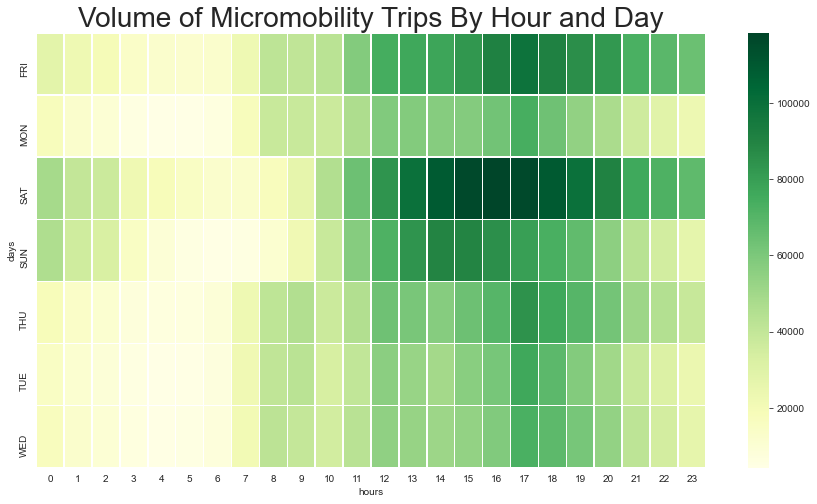

In [56]:
plt.figure(figsize = (15,8))
plt.title("Volume of Micromobility Trips By Hour and Day", fontsize = 28)
hours_heatmap = hours_final.pivot("days", "hours", "count")
ax = sns.heatmap(hours_heatmap,cmap="YlGn",linewidths=.5)

In [49]:
week_month = austin.select("Day of Week","Month")
bymonth  = week_month.groupBy(["Day of Week","Month"]).count().collect()
days_heat2 = [item[0] for item in bymonth]
months_heat2 = [item[1] for item in bymonth]
count_heat2 = [item[2] for item in bymonth]
weekmonth_final = {"count": count_heat2, "months": months_heat2, "days": days_heat2}
month_heat = pd.DataFrame(weekmonth_final)
#usage_bymonth = pd.DataFrame.from_dict(usage_bymonth, orient='index')
month_heat = month_heat.sort_values(by = "months", ascending  = True)

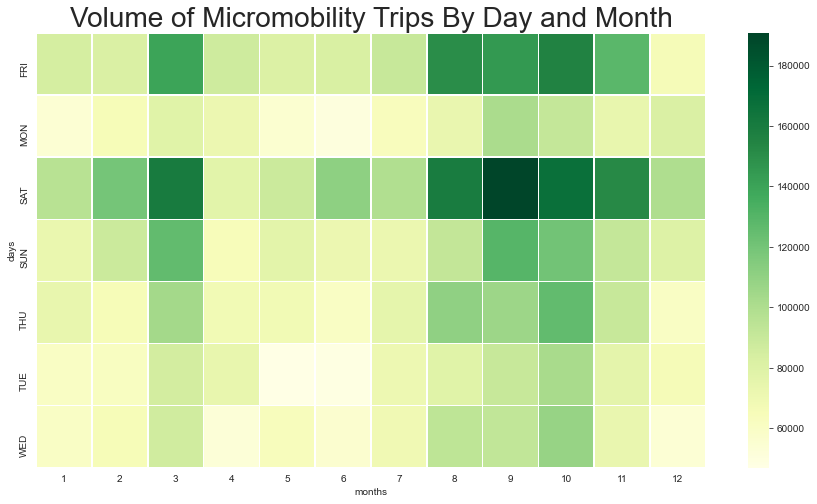

In [55]:
plt.figure(figsize = (15,8))
plt.title("Volume of Micromobility Trips By Day and Month", fontsize = 28)
usage = usage_bymonth.pivot("days", "months", "count")
ax = sns.heatmap(usage,cmap="YlGn",linewidths=.5)

# Louisville Trip Visualization Using Kepler

### Due to a high volume of rides, for this visualization we will focus solely on rides that took place in February of 2019.

In [54]:
!pip install keplergl

In [33]:
louis = pd.read_csv("louisville.csv")
louis.head()

,TripID,StartDate,StartTime,EndDate,EndTime,TripDuration,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum
0,0000045c-2677-3a7d-4b73-cad99a57,2019-06-26,19:30,2019-06-26,19:30,3.0,0.000,38.253,-85.756,38.253,-85.755,4,19
1,0000487b-92e6-50d6-7569-42ed3818,2019-09-22,14:30,2019-09-22,14:30,5.0,0.000,38.203,-85.752,38.204,-85.751,1,14
2,00006088-2579-e0d0-6a30-a15bb878,2019-08-21,17:30,2019-08-21,17:30,6.0,0.330,38.259,-85.733,38.265,-85.739,4,17
3,00008c1a-899b-8596-970f-9f6bf495,2019-07-03,11:00,2019-07-03,11:15,6.0,0.640,38.217,-85.757,38.221,-85.763,4,11
4,00009301-3225-2aea-a84a-165a480a,2019-11-22,10:45,2019-11-22,11:00,7.0,0.599,38.215,-85.759,38.222,-85.764,6,10


In [34]:
louis['StartDate'] =  pd.to_datetime(louis['StartDate'], format='%Y-%m-%d')
louis['EndDate'] =  pd.to_datetime(louis['EndDate'], format='%Y-%m-%d')



In [35]:
louis_feb2019 = louis.set_index('StartDate')
louis_feb2019.head()

,TripID,StartTime,EndDate,EndTime,TripDuration,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum
StartDate,,,,,,,,,,,,
2019-06-26,0000045c-2677-3a7d-4b73-cad99a57,19:30,2019-06-26,19:30,3.0,0.000,38.253,-85.756,38.253,-85.755,4,19
2019-09-22,0000487b-92e6-50d6-7569-42ed3818,14:30,2019-09-22,14:30,5.0,0.000,38.203,-85.752,38.204,-85.751,1,14
2019-08-21,00006088-2579-e0d0-6a30-a15bb878,17:30,2019-08-21,17:30,6.0,0.330,38.259,-85.733,38.265,-85.739,4,17
2019-07-03,00008c1a-899b-8596-970f-9f6bf495,11:00,2019-07-03,11:15,6.0,0.640,38.217,-85.757,38.221,-85.763,4,11
2019-11-22,00009301-3225-2aea-a84a-165a480a,10:45,2019-11-22,11:00,7.0,0.599,38.215,-85.759,38.222,-85.764,6,10


In [36]:
louis_feb2019 = louis_feb2019.loc['2019-02-01':'2019-02-28']
louis_feb2019 = louis_feb2019.sort_index()
louis_feb2019

,TripID,StartTime,EndDate,EndTime,TripDuration,TripDistance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum
StartDate,,,,,,,,,,,,
2019-02-01,a0c944ac-e7a3-96d3-5d8f-5ee2c7ab,05:00,2019-02-01,05:15,11.0,1.62,38.226,-85.776,38.222,-85.751,6,5
2019-02-01,80cdd376-1406-f5d1-13ff-f52defa4,12:15,2019-02-01,12:15,3.0,0.45,38.220,-85.753,38.223,-85.759,6,12
2019-02-01,f9317aaa-000e-50c9-50c9-cec0f493,10:00,2019-02-01,10:00,5.0,0.61,38.220,-85.757,38.214,-85.760,6,10
2019-02-01,aa155df0-33b2-22ee-7574-2f11bebe,09:45,2019-02-01,09:45,4.0,0.32,38.217,-85.763,38.221,-85.764,6,9
2019-02-01,bd2353d9-a129-45c8-9a8e-b939f9ad,21:15,2019-02-01,21:30,15.0,0.35,38.227,-85.755,38.227,-85.755,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-28,35f36db6-567d-8ea9-5de4-e9a8258e,12:45,2019-02-28,12:45,4.0,0.25,38.213,-85.763,38.213,-85.764,5,12
2019-02-28,bffff340-a1be-15da-3132-d33a9213,07:00,2019-02-28,07:00,6.0,1.08,38.218,-85.759,38.222,-85.767,5,7
2019-02-28,bff8ccb8-82b4-2460-f746-6476769d,20:15,2019-02-28,20:15,2.0,0.27,38.223,-85.764,38.221,-85.763,5,20


In [37]:
from keplergl import KeplerGl
map1=KeplerGl(height = 700, width = 500)
map1.add_data(data=louis_feb2019,name='February 2019 Louisville Trips')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [38]:
map1

KeplerGl(data={'February 2019 Louisville Trips': {'index': [Timestamp('2019-02-01 00:00:00'), Timestamp('2019-…

In [41]:
louis_feb2019.to_csv('louisville February 2019 trips', index=True)